## CSE7052 Natural Language Proccessing - Midterm Project

### Nazım Anıl Tepe

At the beginning of the project, the below file-wise adjustments have been made on the dataset.

- The directory named "Yıldırım Bayazıt Üniversitesi json" was under the directory "Maltepe Üniversitesi Json" as a duplicate, has been removed.
- There was a redundant character "]" at line 12 in the file "İstanbul Hukuk Mecmuası 145.json" and it was breaking the JSON structure, character has been removed.
- The file "Ankara Üniversitesi 56.pdf.json" has been deleted because there was nothing in it.
- The file "Ankara Üniversitesi 218.pdf.json" has been deleted because there was insufficient data in it.
- The file "Ankara Üniversitesi 84.pdf.json" has been deleted because it was Spanish entirely.
- The file "Ankara Üniversitesi 86.pdf.json" has been deleted because it was Italian entirely.
- The file "Ankara Üniversitesi 216.pdf.json" had missing parts, has been completed from the original paper.
- The file "Ankara Üniversitesi 217.pdf.json" had missing parts, has been completed from the original paper.
- The file "Gazi Üniversitesi 6.pdf.json" had missing parts, has been completed from the original paper.
- In the file "İstanbul Hukuk Mecmuası 104.json", there was two separate keywords supposed to be combined ("madde" and "791"), they have been combined ("madde 791").

In [2]:
import os
import json
import unicodedata
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import TruncatedSVD
import gensim

In [3]:
json_data = []
for path, dirs, files in os.walk(f"./TrainingSet"):
    for file in files:
        if file.endswith(".json"):
            f = open(os.path.join(path, file), encoding="utf-8-sig")
            json_data.append(json.load(f))
            json_data[-1]["FileName"] = file
            f.close()

In [4]:
CHAR_CONVERSION = {9:32,10:32,33:32,35:32,38:32,40:32,41:32,42:32,43:32,47:45,58:32,59:32,60:-1,61:32,62:-1,63:32,64:32,91:-1,93:-1,94:39,95:45,96:39,123:-1,124:32,125:-1,160:32,167:32,170:-1,171:32,176:-1,180:39,182:-1,184:-1,187:32,223:-1,224:97,225:97,226:97,228:97,229:97,230:101,232:101,233:101,234:101,235:101,236:105,237:105,238:105,239:105,241:110,242:111,243:111,244:111,245:111,248:111,249:117,250:117,251:117,257:97,261:97,263:99,269:99,279:101,299:105,322:108,324:110,353:115,363:117,369:252,382:122,523:105,537:351,601:101,699:39,700:39,703:39,706:-1,714:39,727:-1,774:{103: 287},775:{105: 105},8201:32,8208:45,8211:45,8212:45,8216:39,8217:39,8220:-1,8221:-1,8232:32, }
STRING_CONVERSION = {"$": "dolar","…": " ","ﬀ": "ff","ﬁ": "fi","ﬂ ": "fl","ﬂ": "fl","ﬄ": "ffl","n°": "no","N°": "no","Anahtar Kelimeler:": "","I": "ı","İ": "i","⅔": "%67","⅕": "%20","⅘": "%80","⅚": "%83","¼": "%25","½": "%50","¾": "%75",}
REGEX_CONVERSION = {r"cov[ı,i]d-*\s*19": "covid19",r"(\smd?\.?\s{0,2})((\d)+)": r" madde \2",r"<([a-z]+)(?![^>]*\/>)[^>]*>": "",r"\.": " ",r"-": " ",r"'": " ",r"(\s(%)(\s){0,2})((\d)*)": r" yüzde \4", r"%": "", r"hükumet": "hükümet", r"ışletme": "işletme", r"prepayment": "önödeme", r"arabulucui": "arabulucu"}
ABBREVIATIONS = {r"(^|\s)(smk)($|\s|\.)":r"\1sınai mülkiyet kanunu\3", r"(^|\s)(t?mk)($|\s|\.)": r"\1türk medeni kanunu\3", r"(^|\s)(t?ck)($|\s|\.)": r"\1türk ceza kanunu\3", r"(^|\s)(t?bk)($|\s|\.)": r"\1türk borçlar kanunu\3", r"(^|\s)(t?tk)($|\s|\.)": r"\1türk ticaret kanunu\3", r"(^|\s)(t?vk)($|\s|\.)": r"\1türk vergi kanunu\3", r"(^|\s)(a(b|t)ad)($|\s|\.)": r"\1avrupa birliği adalet divanı\4", r"(^|\s)(abd)($|\s|\.)": r"\1amerika birleşik devletleri\3", r"(^|\s)(ab)($|\s|\.)": r"\1avrupa birliği\3", r"(^|\s)(bm)($|\s|\.)": r"\1birleşmiş milletler\3", r"(^|\s)(a(i|ı)hm)($|\s|\.)": r"\1avrupa insan hakları mahkemesi\4", r"(^|\s)(a(i|ı)hs)($|\s|\.)": r"\1avrupa insan hakları sözleşmesi\4", r"(^|\s)(möhuk)($|\s|\.)": r"\1milletlerarası özel hukuk ve usul hukuku\3", r"(^|\s)(fsek)($|\s|\.)": r"\1fikir ve sanat eserleri kanunu\3", r"(^|\s)(kktc)($|\s|\.)": r"\1kuzey kıbrıs türk cumhuriyeti\3", r"(^|\s)([ey]?tkhk)($|\s|\.)": r"\1tüketicinin korunması hakkında kanun\3", r"(^|\s)(khk)($|\s|\.)": r"\1kanun hükmünde kararname\3"}

In [5]:
sw_file = open('./stopwords.txt')
stop_words = sw_file.read()
stop_words = stop_words.split("\n")
sw_file.close()

In [6]:
def clean_text(string, kw=False):
    for key in STRING_CONVERSION.keys():
        string = string.replace(key, STRING_CONVERSION[key])
    string = string.lower()
    result = []
    for char in string:
        if unicodedata.combining(char):
            try:
                result[-1] = chr(CHAR_CONVERSION[ord(char)][ord(result[-1])])
            except:
                continue
        elif ord(char) in CHAR_CONVERSION.keys():
            if CHAR_CONVERSION[ord(char)] != -1:
                result.append(chr(CHAR_CONVERSION[ord(char)]))
        elif ord(char) >= 942:
            continue
        else:
            result.append(char)
    result_str = ''.join(result)
    result_str = ' '.join([w for w in result_str.split(" ") if w != ""])
    for key in ABBREVIATIONS.keys():
        result_str = re.sub(key, ABBREVIATIONS[key], result_str)
    if kw:
        for key in REGEX_CONVERSION.keys():
            result_str = re.sub(key, REGEX_CONVERSION[key], result_str)
    return((result_str).strip())

In [7]:
def clean_list(li, kw=False):
    clean_list = []
    for item in li:
        if len(item.split(",")) > 1:
            clean_list.extend([it for it in item.split(",") if it != ""])
        elif len(item.split(";")) > 1:
            clean_list.extend([it for it in item.split(";") if it != ""])
        else:
            clean_list.append(item)
    clean_list = [clean_text(text, kw) for text in clean_list if text != ""]
    if not kw:
        clean_str = ' '.join(clean_list)
        for key in REGEX_CONVERSION.keys():
            clean_str = re.sub(key, REGEX_CONVERSION[key], clean_str)
        clean_list = [part for part in clean_str.split(" ") if part != ""]
        clean_list = [text for text in clean_list if text not in stop_words]
    if kw:
        clean_list = list(dict.fromkeys(clean_list))
    clean_list = [text for text in clean_list if text != ""]
    return clean_list

In [8]:
for data_obj in json_data:
    data_obj["Metin"] = re.sub(r"[-\w\.]+@([-\w]+\.)+[-\w]{2,4}", "", data_obj["Metin"])
    data_obj["Metin"] = re.sub(r"https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=]*)", "", data_obj["Metin"])
    data_obj["Metin"] = re.sub(r"<([a-z]+)(?![^>]*\/>)[^>]*>", "", data_obj["Metin"])

In [10]:
words = [(data_obj["FileName"], clean_list(data_obj["Metin"].split(" "))) for data_obj in json_data]
words = [(wtup[0], len(wtup[1]), wtup[1]) for wtup in words]

In [11]:
keywords = [(data_obj["FileName"], clean_list(data_obj["Anahtar Kelimeler"], True)) for data_obj in json_data]
keywords = [(kwtup[0], len(kwtup[1]), kwtup[1]) for kwtup in keywords]

In [33]:
X = [wtup[2] for wtup in words]
y = [kwtup[2] for kwtup in keywords]
data = [[' '.join(words[i][2]), ','.join(keywords[i][2])] for i,_ in enumerate(words)]
df = pd.DataFrame(data, columns = ['text', 'tags'])
df.head()

,text,tags
0,anonim ortaklıkların amacı kime hizmet ettiği ...,"menfaat sahipliği teorisi,insan sermayesi,takı..."
1,uluslararası kamu hukuku devletlerin kimi zama...,"ısrarlı itirazcı,itiraz,teamül hukuku,uluslara..."
2,vesayet altındaki kişinin malvarlığının yöneti...,"vesayet,vasi,vesayet makamı,vesayet altındaki ..."
3,dolandırıcılık doğru davranma iyiniyet kuralla...,"türk ceza kanunu,suç,ceza,hile,dolandırıcılık,..."
4,türkiye 2019 yılının ilk altı ayında yaklaşık ...,"gümrük,döviz,mülkiyet hakkı,idari para cezası,..."


In [34]:
df["tags_count"] = df["tags"].apply(lambda x: len(x.split(",")))
df["tags_count"].value_counts().head()

tags_count
5    451
4     89
6     75
3     41
7     26
Name: count, dtype: int64

As can be seen, the majority of the documents have 5 keywords.

In [35]:
vec_count = CountVectorizer(tokenizer = lambda x: x.split(","))
tags_bow = vec_count.fit_transform(df['tags'])
tags_bow.shape

(717, 2905)

There are 2905 unique keywords (tags).

In [36]:
tags = vec_count.get_feature_names_out()
tags_freq = tags_bow.sum(axis=0).A1
tags_count = dict(zip(tags, tags_freq))
tags[0:5]

array(['12 aylık hoşgörü süresi',
       '1808 tarihli fransız ceza muhakemesi kanunu',
       '1855 ve 1884 fransız', '1858 ceza kanunu',
       '1864 ve 1871 osmanlı vilayet nizamnameleri'], dtype=object)

In [37]:
tcount_list = []
for key, value in tags_count.items():
  tcount_list.append([key, value]) 
tcount_df = pd.DataFrame(tcount_list, columns=['tags', 'counts'])
tcount_df_sorted = tcount_df.sort_values(['counts'], ascending=False)
tcount_df_sorted.head()

,tags,counts
459,covid19,20
50,adil yargılanma hakkı,19
1757,mülkiyet hakkı,13
134,anayasa mahkemesi,12
132,anayasa,11


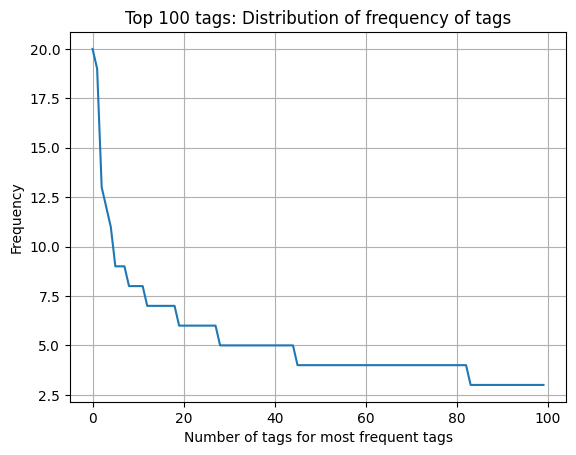

In [38]:
plt.plot(tcount_df_sorted['counts'][0:100].values)
plt.grid()
plt.title("Top 100 tags: Distribution of frequency of tags")
plt.xlabel("Number of tags for most frequent tags")
plt.ylabel("Frequency")
plt.show()

In [39]:
vec_binary = CountVectorizer(tokenizer = lambda x: x.split(","), binary=True)
y_multilabel = vec_binary.fit_transform(df['tags'])

In [40]:
df_tags = pd.DataFrame(df["tags"].apply(lambda x: x.split(",")).to_list())
df_tags_flat = pd.concat([df_tags[col] for col in df_tags])
df_tags_unique = df_tags_flat.unique()

In [41]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(df_tags_unique)
y_encoded = np.array(df_tags.apply(lambda x: label_encoder.transform(x)))

In [42]:
def binarize_encoding(row):
    a = label_encoder.inverse_transform(row)
    a = a[a != np.array(None)]
    a = np.unique(a)
    return sum(vec_binary.transform(a)).toarray()[0]

#### Approach 1
Logistic Regression with Dense Input Data (Word2Vec) & Label Encoded Multioutput Data

In [72]:
VEC_SIZE = 200
vec_word2vec = gensim.models.Word2Vec(X, min_count = 1, vector_size = VEC_SIZE, window = 10)

In [73]:
X_np = np.zeros((len(X), VEC_SIZE))
for i, row in enumerate(X):
    for word in row:
        X_np[i] += vec_word2vec.wv[word]
    X_np[i] /= len(row)

In [74]:
clf_logr = MultiOutputClassifier(LogisticRegression(solver='liblinear'))

In [75]:
k = 10
kf = KFold(n_splits=k)

scores_logr = np.zeros((k, 6))
k_idx = 0
for train_index, test_index in kf.split(X_np, y_encoded):
    X_train, X_test = X_np[train_index, :], X_np[test_index, :]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    print("#", k_idx + 1, "Training:", X_train.shape, y_train.shape, "Test:", X_test.shape, y_test.shape)
    
    clf_logr.fit(X_train, y_train)
    y_pred = clf_logr.predict(X_test)
    y_test_bin = np.array([binarize_encoding(row) for row in y_test])
    y_pred_bin = np.array([binarize_encoding(row) for row in y_pred])
    acc = metrics.accuracy_score(y_test_bin, y_pred_bin)
    prem = metrics.precision_score(y_test_bin, y_pred_bin, average = 'micro')
    prew = metrics.precision_score(y_test_bin, y_pred_bin, average = 'weighted')
    recl = metrics.recall_score(y_test_bin, y_pred_bin, average = 'micro')
    mif1 = metrics.f1_score(y_test_bin, y_pred_bin, average = 'micro')
    maf1 = metrics.f1_score(y_test_bin, y_pred_bin, average = 'macro')
    scores_logr[k_idx,:] = np.array([acc, prem, prew, recl, mif1, maf1])
    k_idx += 1

# 1 Training: (645, 200) (645, 14) Test: (72, 200) (72, 14)
# 2 Training: (645, 200) (645, 14) Test: (72, 200) (72, 14)
# 3 Training: (645, 200) (645, 14) Test: (72, 200) (72, 14)
# 4 Training: (645, 200) (645, 14) Test: (72, 200) (72, 14)
# 5 Training: (645, 200) (645, 14) Test: (72, 200) (72, 14)
# 6 Training: (645, 200) (645, 14) Test: (72, 200) (72, 14)
# 7 Training: (645, 200) (645, 14) Test: (72, 200) (72, 14)
# 8 Training: (646, 200) (646, 14) Test: (71, 200) (71, 14)
# 9 Training: (646, 200) (646, 14) Test: (71, 200) (71, 14)
# 10 Training: (646, 200) (646, 14) Test: (71, 200) (71, 14)


In [76]:
avg_scores_logr = scores_logr.mean(axis=0)

In [77]:
print('Logistic Regression accuracy : {}'.format(avg_scores_logr[0]))
print('Logistic Regression micro precision : {}'.format(avg_scores_logr[1]))
print('Logistic Regression weighted precision : {}'.format(avg_scores_logr[2]))
print('Logistic Regression recall : {}'.format(avg_scores_logr[3]))
print('Logistic Regression micro f1 : {}'.format(avg_scores_logr[4]))
print('Logistic Regression macro f1 : {}'.format(avg_scores_logr[5]))

Logistic Regression accuracy : 0.0
Logistic Regression micro precision : 0.08279088941754865
Logistic Regression weighted precision : 0.03668833693149239
Logistic Regression recall : 0.05125733295951951
Logistic Regression micro f1 : 0.06324559056969745
Logistic Regression macro f1 : 0.0040214003033178895


#### Approach 2
Multinomial Naive-Bayes with Sparse Input Data (TF-IDF) & Label Encoded Multioutput Data

In [80]:
vec_tfidf = TfidfVectorizer(max_df=0.5, min_df=0.0009, max_features=100000, tokenizer = lambda x: x.split(), ngram_range=(1, 3))

In [78]:
clf_mnnb = MultiOutputClassifier(MultinomialNB(fit_prior=True, class_prior=None))

In [82]:
k = 10
kf = KFold(n_splits=k)

scores_mnnb = np.zeros((k, 6))
k_idx = 0
for train_index, test_index in kf.split(df, y_encoded):
    X_train, X_test = df.iloc[train_index, :], df.iloc[test_index, :]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    X_train_tfidf = vec_tfidf.fit_transform(X_train['text'])
    X_test_tfidf = vec_tfidf.transform(X_test['text'])
    
    print("#", k_idx + 1, "Training:", X_train_tfidf.shape, y_train.shape, "Test:", X_test_tfidf.shape, y_test.shape)
    
    clf_mnnb.fit(X_train_tfidf, y_train)
    y_pred = clf_mnnb.predict(X_test_tfidf)
    y_test_bin = np.array([binarize_encoding(row) for row in y_test])
    y_pred_bin = np.array([binarize_encoding(row) for row in y_pred])
    acc = metrics.accuracy_score(y_test_bin, y_pred_bin)
    prem = metrics.precision_score(y_test_bin, y_pred_bin, average = 'micro')
    prew = metrics.precision_score(y_test_bin, y_pred_bin, average = 'weighted')
    recl = metrics.recall_score(y_test_bin, y_pred_bin, average = 'micro')
    mif1 = metrics.f1_score(y_test_bin, y_pred_bin, average = 'micro')
    maf1 = metrics.f1_score(y_test_bin, y_pred_bin, average = 'macro')
    scores_mnnb[k_idx,:] = np.array([acc, prem, prew, recl, mif1, maf1])
    k_idx += 1

# 1 Training: (645, 100000) (645, 14) Test: (72, 100000) (72, 14)
# 2 Training: (645, 100000) (645, 14) Test: (72, 100000) (72, 14)
# 3 Training: (645, 100000) (645, 14) Test: (72, 100000) (72, 14)
# 4 Training: (645, 100000) (645, 14) Test: (72, 100000) (72, 14)
# 5 Training: (645, 100000) (645, 14) Test: (72, 100000) (72, 14)
# 6 Training: (645, 100000) (645, 14) Test: (72, 100000) (72, 14)
# 7 Training: (645, 100000) (645, 14) Test: (72, 100000) (72, 14)
# 8 Training: (646, 100000) (646, 14) Test: (71, 100000) (71, 14)
# 9 Training: (646, 100000) (646, 14) Test: (71, 100000) (71, 14)
# 10 Training: (646, 100000) (646, 14) Test: (71, 100000) (71, 14)


In [83]:
avg_scores_mnnb = scores_mnnb.mean(axis=0)

In [84]:
print('Naive Bayes accuracy : {}'.format(avg_scores_mnnb[0]))
print('Naive Bayes micro precision : {}'.format(avg_scores_mnnb[1]))
print('Naive Bayes weighted precision : {}'.format(avg_scores_mnnb[2]))
print('Naive Bayes recall : {}'.format(avg_scores_mnnb[3]))
print('Naive Bayes micro f1 : {}'.format(avg_scores_mnnb[4]))
print('Naive Bayes macro f1 : {}'.format(avg_scores_mnnb[5]))

Naive Bayes accuracy : 0.0
Naive Bayes micro precision : 0.032063530511370765
Naive Bayes weighted precision : 0.00807268125298313
Naive Bayes recall : 0.018021449190952606
Naive Bayes micro f1 : 0.023051387218976087
Naive Bayes macro f1 : 0.0006777351841988766


#### Approach 3
MLP Classifier with Dense Input Data (Word2Vec) & Label Encoded Multioutput Data

In [90]:
clf_mlp = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(100,2)))

In [91]:
k = 10
kf = KFold(n_splits=k)

scores_mlp = np.zeros((k, 6))
k_idx = 0
for train_index, test_index in kf.split(X_np, y_encoded):
    X_train, X_test = X_np[train_index, :], X_np[test_index, :]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    
    print("#", k_idx + 1, "Training:", X_train.shape, y_train.shape, "Test:", X_test.shape, y_test.shape)
    
    clf_mlp.fit(X_train, y_train)
    y_pred = clf_mlp.predict(X_test)
    y_test_bin = np.array([binarize_encoding(row) for row in y_test])
    y_pred_bin = np.array([binarize_encoding(row) for row in y_pred])
    acc = metrics.accuracy_score(y_test_bin, y_pred_bin)
    prem = metrics.precision_score(y_test_bin, y_pred_bin, average = 'micro')
    prew = metrics.precision_score(y_test_bin, y_pred_bin, average = 'weighted')
    recl = metrics.recall_score(y_test_bin, y_pred_bin, average = 'micro')
    mif1 = metrics.f1_score(y_test_bin, y_pred_bin, average = 'micro')
    maf1 = metrics.f1_score(y_test_bin, y_pred_bin, average = 'macro')
    scores_mlp[k_idx,:] = np.array([acc, prem, prew, recl, mif1, maf1])
    k_idx += 1

# 1 Training: (645, 200) (645, 14) Test: (72, 200) (72, 14)
# 2 Training: (645, 200) (645, 14) Test: (72, 200) (72, 14)
# 3 Training: (645, 200) (645, 14) Test: (72, 200) (72, 14)
# 4 Training: (645, 200) (645, 14) Test: (72, 200) (72, 14)
# 5 Training: (645, 200) (645, 14) Test: (72, 200) (72, 14)
# 6 Training: (645, 200) (645, 14) Test: (72, 200) (72, 14)
# 7 Training: (645, 200) (645, 14) Test: (72, 200) (72, 14)
# 8 Training: (646, 200) (646, 14) Test: (71, 200) (71, 14)
# 9 Training: (646, 200) (646, 14) Test: (71, 200) (71, 14)
# 10 Training: (646, 200) (646, 14) Test: (71, 200) (71, 14)


In [92]:
avg_scores_mlp = scores_mlp.mean(axis=0)

In [93]:
print('MLP accuracy : {}'.format(avg_scores_mlp[0]))
print('MLP micro precision : {}'.format(avg_scores_mlp[1]))
print('MLP weighted precision : {}'.format(avg_scores_mlp[2]))
print('MLP recall : {}'.format(avg_scores_mlp[3]))
print('MLP micro f1 : {}'.format(avg_scores_mlp[4]))
print('MLP macro f1 : {}'.format(avg_scores_mlp[5]))

MLP accuracy : 0.0
MLP micro precision : 0.010784580514448342
MLP weighted precision : 0.002174627202929247
MLP recall : 0.008367162760816987
MLP micro f1 : 0.009394495086904521
MLP macro f1 : 0.00017753788269273045


#### Approach 4
SGD Classifier with Sparse Input Data (TF-IDF) & Multilabel Binary Output Data with Reduced Class Size

In [43]:
def tags_to_include(n):
    tags_sum = y_multilabel.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(tags_sum)), key=lambda i: tags_sum[i], reverse=True)
    yn_multilabel = y_multilabel[:, sorted_tags_i[:n]]
    return yn_multilabel

def no_of_included_docs(n):
    yn_multilabel = tags_to_include(n)
    x = yn_multilabel.sum(axis=1)
    return (np.count_nonzero(x == 0))

In [44]:
docs_included = []
tags_total = y_multilabel.shape[1]
docs_total = df.shape[0]
for i in range(100, tags_total, 100):
    docs_included.append(np.round(((docs_total - no_of_included_docs(i)) / docs_total) * 100, 3))

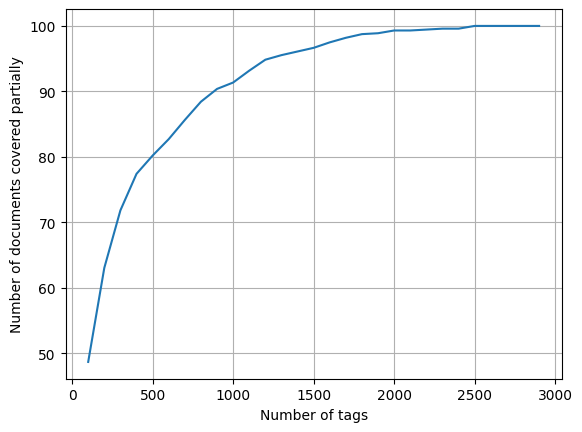

%91.353 of documents covered by 1000 tags
Number of documents that are not covered by 1000 tags: 62 out of 717


In [45]:
plt.plot(np.arange(100, tags_total, 100), docs_included)
plt.xlabel("Number of tags")
plt.ylabel("Number of documents covered partially")
plt.grid()
plt.show()
print(f"%{docs_included[9]} of documents covered by 1000 tags")
print("Number of documents that are not covered by 1000 tags:", no_of_included_docs(1000), "out of", docs_total)

In [46]:
yn_multilabel = tags_to_include(1000)
print("Number of tags in the subset:", y_multilabel.shape[1])
print("Number of tags considered:", yn_multilabel.shape[1], f"(%{np.round((yn_multilabel.shape[1] / y_multilabel.shape[1]) * 100, 3)})")

Number of tags in the subset: 2905
Number of tags considered: 1000 (%34.423)


In [53]:
df['tags_reduced'] = [sum(yn_multilabel[i].toarray()[0]) for i in range(yn_multilabel.shape[0])]
df_reduced = df[df['tags_reduced'] != 0]
yn_reduced = yn_multilabel[df['tags_reduced'] != 0]
print(df_reduced.shape[0], yn_reduced.shape)

655 (655, 1000)


In [48]:
vec_tfidf = TfidfVectorizer(max_df=0.5, min_df=0.0009, max_features=200000, tokenizer = lambda x: x.split(), ngram_range=(1, 4))

In [49]:
clf_sgd = OneVsRestClassifier(SGDClassifier(loss='log_loss', alpha=0.0001, penalty='l1'))

In [54]:
k = 10
kf = KFold(n_splits=k)

scores_sgd = np.zeros((k, 6))
k_idx = 0
for train_index, test_index in kf.split(df_reduced, yn_reduced):
    X_train, X_test = df_reduced.iloc[train_index, :], df_reduced.iloc[test_index, :]
    y_train, y_test = yn_reduced[train_index], yn_reduced[test_index]
    
    X_train_tfidf = vec_tfidf.fit_transform(X_train['text'])
    X_test_tfidf = vec_tfidf.transform(X_test['text'])
    
    print("#", k_idx + 1, "Training:", X_train_tfidf.shape, y_train.shape, "Test:", X_test_tfidf.shape, y_test.shape)
    
    clf_sgd.fit(X_train_tfidf, y_train)
    y_pred = clf_sgd.predict(X_test_tfidf)
    acc = metrics.accuracy_score(y_test, y_pred)
    prem = metrics.precision_score(y_test, y_pred, average = 'micro')
    prew = metrics.precision_score(y_test, y_pred, average = 'weighted')
    recl = metrics.recall_score(y_test, y_pred, average = 'micro')
    mif1 = metrics.f1_score(y_test, y_pred, average = 'micro')
    maf1 = metrics.f1_score(y_test, y_pred, average = 'macro')
    scores_sgd[k_idx,:] = np.array([acc, prem, prew, recl, mif1, maf1])
    k_idx += 1

# 1 Training: (589, 200000) (589, 1000) Test: (66, 200000) (66, 1000)
# 2 Training: (589, 200000) (589, 1000) Test: (66, 200000) (66, 1000)
# 3 Training: (589, 200000) (589, 1000) Test: (66, 200000) (66, 1000)
# 4 Training: (589, 200000) (589, 1000) Test: (66, 200000) (66, 1000)
# 5 Training: (589, 200000) (589, 1000) Test: (66, 200000) (66, 1000)
# 6 Training: (590, 200000) (590, 1000) Test: (65, 200000) (65, 1000)
# 7 Training: (590, 200000) (590, 1000) Test: (65, 200000) (65, 1000)
# 8 Training: (590, 200000) (590, 1000) Test: (65, 200000) (65, 1000)
# 9 Training: (590, 200000) (590, 1000) Test: (65, 200000) (65, 1000)
# 10 Training: (590, 200000) (590, 1000) Test: (65, 200000) (65, 1000)


In [55]:
avg_scores_sgd = scores_sgd.mean(axis=0)

In [56]:
print('SGD Classifier accuracy : {}'.format(avg_scores_sgd[0]))
print('SGD Classifier micro precision : {}'.format(avg_scores_sgd[1]))
print('SGD Classifier weighted precision : {}'.format(avg_scores_sgd[2]))
print('SGD Classifier recall : {}'.format(avg_scores_sgd[3]))
print('SGD Classifier micro f1 : {}'.format(avg_scores_sgd[4]))
print('SGD Classifier macro f1 : {}'.format(avg_scores_sgd[5]))

SGD Classifier accuracy : 0.010675990675990676
SGD Classifier micro precision : 0.5944445750328102
SGD Classifier weighted precision : 0.07684619536187642
SGD Classifier recall : 0.06006835849953871
SGD Classifier micro f1 : 0.10801563378720018
SGD Classifier macro f1 : 0.008775238095238095
